# Análise de Séries Temporais(Cap 12) - Pense Estatística, 2º Edição.

## Universidade Federal de Alagoas - UFAL
## Centro de Tecnologia - CTEC
## Programa de Pós-Graduação Recursos Hídricos e Saneamento - PPGRHS
### Disciplina de Estatística

Clebson Farias

In [4]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random

import thinkstats2
import thinkplot

In [5]:
#Dados Manso
dados = pd.read_csv("manso.csv", index_col=0, parse_dates=True)
evap = pd.read_csv("evaporacao.csv", sep=';', index_col="Data", parse_dates=True, dayfirst=True)["Evaporacao Piche"].rename("Evap_CUIABA")
evap1 = pd.read_csv("evaporacao2.csv", sep=';', index_col="Data", parse_dates=True, dayfirst=True)["Evaporacao Piche"].rename("Evap_RICAR")
evap2 = pd.read_csv("evaporacao3.csv", sep=';', index_col="Data", parse_dates=True, dayfirst=True)["Evaporacao Piche"].rename("Evap_DIAM")
dados = dados.combine_first(pd.DataFrame(evap))
dados = dados.combine_first(pd.DataFrame(evap1))
dados = dados.combine_first(pd.DataFrame(evap2))
date_start = pd.to_datetime("01/01/1982", dayfirst=True)
date_end = pd.to_datetime("31/12/1986", dayfirst=True)
dados = dados.loc[date_start:date_end]
dados.rename(index=str, 
             columns={"1455008": "COIMBRA_P", "66210000": "MANSO_JUS", "66231000": "COIMBRA_F"}, 
             inplace=True)
dados.index = pd.to_datetime(dados.index, errors='coerce')
dados.head()

,COIMBRA_P,MANSO_JUS,COIMBRA_F,Evap_CUIABA,Evap_DIAM,Evap_RICAR,MANSO
1982-01-01,0.0,NaN,248.865,2.3,1.2,NaN,243.0
1982-01-02,0.0,NaN,333.847,1.3,0.4,NaN,329.0
1982-01-03,0.0,NaN,295.620,2.9,1.1,NaN,290.0
1982-01-04,0.0,NaN,305.919,1.7,0.9,NaN,300.0
1982-01-05,0.0,NaN,387.954,3.7,1.9,NaN,386.0


In [38]:
dados_chuva = pd.Series(dados["COIMBRA_P"].groupby(pd.Grouper(freq='M')).sum(), name='Prec')
dados_vazao_obs = pd.Series(dados["COIMBRA_F"].groupby(pd.Grouper(freq='M')).mean(), name='Obs') 
dados_vazao_nat = pd.Series(dados["MANSO"].groupby(pd.Grouper(freq='M')).mean(), name='Nat')
dados_evap = pd.Series(dados["Evap_CUIABA"].groupby(pd.Grouper(freq='M')).sum())
dados_month = pd.DataFrame([dados_vazao_obs, dados_vazao_nat, dados_chuva, dados_evap]).T
dados_month.head()

,Obs,Nat,Prec,Evap_CUIABA
1982-01-31,399.868226,396.516129,195.2,83.3
1982-02-28,424.485036,435.642857,156.2,76.0
1982-03-31,394.772968,399.838710,78.6,76.9
1982-04-30,292.312400,293.500000,79.0,116.4
1982-05-31,142.554806,141.000000,0.0,110.4


## Média móveis

A análise de séries temporais se baseia na modelação de componentes:
- Tendência: Função suave que identifica alterações persistentes;
- Sazonalidade: Variação periódica, possivelmente incluindo ciclos diários, semanais, mensais ou anuais.
- Ruído: Variação aleatória;

**Regressão** é um caminho para extrair tencência de uma série, muito usual quando é um a **função simples**;

Para **funções complexas**, uma boa alternativa é as **médias móveis**.

As média móveis divide a séries em **janelas**, onde essas, são sobrepostas.

A média móvel mais simples é a **média rolante**, que calcula a média de cada janela.

In [7]:
dados_mv7 = dados_month.Nat.rolling(7).mean()
dados_mv14 = dados_month.Nat.rolling(14).mean()
dados_mv21 = dados_month.Nat.rolling(21).mean()

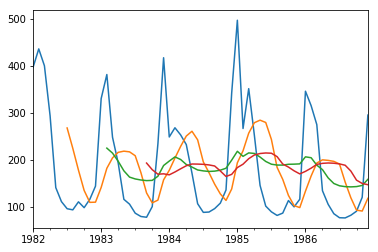

In [8]:
dados_month.Nat.plot()
dados_mv7.plot()
dados_mv14.plot()
dados_mv21.plot()

Existe vários tipos de média móveis, uma boa alternativa é a **média móvel ponderada-exponencialmente**.

Vantagens:
- Primeiro, como o nome sugere, ela **calcula uma média ponderada** onde o **valor mais recente tem o maior peso** e os pesos dos valores anteriores caem exponencialmente. 
- Segundo, trata melhor os valores em falta.

In [9]:
dados_ewm7 = dados_month.Nat.ewm(7).mean()
dados_ewm14 = dados_month.Nat.ewm(14).mean()
dados_ewm21 = dados_month.Nat.ewm(21).mean()

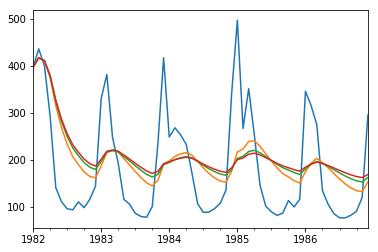

In [10]:
dados_month.Nat.plot()
dados_ewm7.plot()
dados_ewm14.plot()
dados_ewm21.plot()

## Valores ausentes

Os teste de sazonalidade **não funcionam** muito bem quando a série apresenta **falhas**;

## Correlação serial

Correlação serial: Cada valor está correlacionado com o próximo valor da série;

Para calcular a correlação serial, podemos **deslocar a série temporal** por um intervalo chamado lag, e depois **calcular a correlação** da série deslocada **com a original**:

In [11]:
corr_serial = thinkstats2.SerialCorr(dados_month.Nat, lag=1)

print('Correlação serial: ', round(corr_serial, 3))

Correlação serial:  0.699


## Autocorrelação

A função de **autocorrelação** é a correlação serial calculada para todos os atrasos.

**"Autocorrelação"** é outro nome para correlação serial, usado com mais frequência quando o defasagem não é 1.

StatsModel tem uma função que calcula a autocorrelação.

In [12]:
import statsmodels.tsa.stattools as smtsa

acf = smtsa.acf(dados_month.Nat, nlags=10, unbiased=True)
acf

array([ 1.        ,  0.68537049,  0.31105395, -0.02994936, -0.31943587,
       -0.49948087, -0.58979901, -0.55379963, -0.37841092, -0.03968092,
        0.35007995])

## Predição

- Pode ser usada para investigar;
- Fazer predições;
- Explicar comportamentos;

É importante quantificar as incertezas das previsão;
- Erro de Amostragem: Baseada em parâmetros estimados;
- Variações Aleatórias: Variação em torno da tendência;
- Erro de modelagem: Erro em modelos, por exemplo, modelo linear. 

Outro erro pode ser considerado, os **acontecimentos inesperados**;

Erro de amostragem e variações aleatórias são mais fáceis de **quantificar**;

Erros de amostragens podem ser quantificados utilizando **reamostragem**;
